# Interpretability and Explainability LightGBM


## Monotonicity

A key to building interpretable models is to limit their complexity. The more complex a model is, the harder it is to explain and understand. Overly complex models can also make unstable predictions on new data, which is both difficult to explain and makes models harder to trust. Monotonicity constraints not only simplify models, but do so in a way that is somewhat natural for human reasoning, increasing the transparency of predictive models. Under monotonicity constraints, model predictions can only increase or only decrease as an input variable value increases, and the direction of the constraint is typically specified by the user for logical reasons. For instance, a model might be constrained to produce only increasing probabilities of a certain medical condition as a patient's age increases, or to make only increasing predictions for home prices as a home's square footage increases. 

In this notebook a gradient boosting machine (GBM) is trained with monotonicity constraints to predict credit card payment defaults, using the UCI credit card default data, Python, NumPy, Pandas, and XGBoost. First, the credit card default data is loaded and prepared. Then Pearson correlation with the prediction target is used to determine the direction of the monotonicity constraints for each input variable and the model is trained. After the model is trained, partial dependence and individual conditional expectation (ICE) plots are used to analyze and verify the model's monotonic behavior. Finally an example of creating regulator mandated reason codes from high fidelity Shapley explanations for any model prediction is presented. This combination of monotonic XGBoost, partial dependence, ICE, and Shapley explanations is probably the most direct way to create an interpretable machine learning model today.

**Note**: As of the h2o 3.24 "Yates" release, Shapley values are supported in h2o, in addition to GBM monotonicity constraints and partial dependence. To see Shapley values and monotonicity constraints for an h2o GBM in action please see: https://github.com/jphall663/interpretable_machine_learning_with_python/blob/master/dia.ipynb.

#### Python imports 

Let's start with Python package imports. NumPy is used for basic arrray, vector, and matrix calculations. Pandas is used for data frame manipulation and plotting, and XGBoost is used to train a GBM with monotonicity constraints.

In [2]:
!pip install shap

     |████████████████████████████████| 266kB 3.2MB/s 
  Created wheel for shap: filename=shap-0.34.0-cp36-cp36m-linux_x86_64.whl size=383181 sha256=ec747b727abf62b6f52bd15d6353843bdc3c8d5b51868cd2e340b09cbe23c3ad
  Stored in directory: /root/.cache/pip/wheels/28/7e/28/57bc9fcb77579b0df6561298648249370648c0b91dfe42c8ec
Successfully built shap


In [0]:
import numpy as np                   # array, vector, matrix calculations
import pandas as pd                  # DataFrame handling
import shap                          # for consistent, signed variable importance measurements
import lightgbm as lgb                # gradient boosting machines (GBMs)

import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all columns in notebook

# enables display of plots in notebook
%matplotlib inline

np.random.seed(12345)                # set random seed for reproducibility

### 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005. Because XGBoost accepts only numeric inputs, all variables will be treated as numeric.

#### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`. 

In [0]:
# import XLS file
path = 'https://github.com/firmai/random-assets-two/blob/master/xaib/default_of_credit_card_clients.xls?raw=true'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`.

In [5]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Display descriptive statistics
The Pandas `describe()` function displays a brief description of the credit card default data. The input variables `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_0`-`PAY_6`, and the prediction target `DEFAULT_NEXT_MONTH`, are really categorical variables, but they have already been encoded into meaningful numeric, integer values, which is great for XGBoost. Also, there are no missing values in this dataset.

In [6]:
data[X + [y]].describe() # display descriptive statistics for all columns

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


### 2. Investigate pair-wise Pearson correlations for DEFAULT_NEXT_MONTH

Monotonic relationships are much easier to explain to colleagues, bosses, customers, and regulators than more complex, non-monotonic relationships and monotonic relationships may also prevent overfitting and excess error due to variance for new data.

To train a transparent monotonic classifier, contraints must be supplied to XGBoost that determine whether the learned relationship between an input variable and the prediction target `DEFAULT_NEXT_MONTH` will be increasing for increases in an input variable or decreasing for increases in an input variable. Pearson correlation provides a linear measure of the direction of the relationship between each input variable and the target. If the pair-wise Pearson correlation between an input and `DEFAULT_NEXT_MONTH` is positive, it will be constrained to have an increasing relationship with the predictions for `DEFAULT_NEXT_MONTH`. If the pair-wise Pearson correlation is negative, the input will be constrained to have a decreasing relationship with the predictions for `DEFAULT_NEXT_MONTH`. 

Constrainsts are supplied to XGBoost in the form of a Python tuple with length equal to the number of inputs. Each item in the tuple is associated with an input variable based on its index in the tuple. The first constraint in the tuple is associated with the first variable in the training data, the second constraint in the tuple is associated with the second variable in the training data, and so on. The constraints themselves take the form of a 1 for a positive relationship and a -1 for a negative relationship.

#### Calculate Pearson correlation

The Pandas `.corr()` function returns the pair-wise Pearson correlation between variables in a Pandas DataFrame. Because `DEFAULT_NEXT_MONTH` is the last column in the `data` DataFrame, the last column of the Pearson correlation matrix indicates the direction of the linear relationship between each input variable and the prediction target, `DEFAULT_NEXT_MONTH`. According to the calculated values, as a customer's balance limit (`LIMIT_BAL`), bill amounts (`BILL_AMT1`-`BILL_AMT6`), and payment amounts (`PAY_AMT1`-`PAY_AMT6`) increase, their probability of default tends to decrease. However as a customer's number of late payments increase (`PAY_0`, `PAY_2`-`PAY6`), their probability of default usually increases. In general, the Pearson correlation values make sense, and they will be used to ensure that the modeled relationships will make sense as well. (Pearson correlation values between the target variable, DEFAULT_NEXT_MONTH, and each input variable are displayed directly below.)

In [7]:
# coul dyou substitute correlation, probably not, still one dimensionally descriptive. 
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1] 

,DEFAULT_NEXT_MONTH
LIMIT_BAL,-0.153520
SEX,-0.039961
EDUCATION,0.028006
MARRIAGE,-0.024339
AGE,0.013890
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149


#### Create tuple of monotonicity constraints from Pearson correlation values

The last column of the Pearson correlation matrix is transformed from a numeric column in a Pandas DataFrame into a Python tuple of `1`s and `-1`s that will be used to specifiy monotonicity constraints for each input variable in XGBoost. If the Pearson correlation between an input variable and `DEFAULT_NEXT_MONTH` is positive, a positive montonic relationship constraint is specified for that variable using `1`. If the correlation is negative, a negative monotonic constraint is specified using `-1`. (Specifying `0` indicates that no constraints should be used.) The resulting tuple will be passed to XGBoost when the GBM model is trained.

In [0]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = list([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])
mono_str = ','.join(map(str, mono_constraints))
# (-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)

### 3. Train XGBoost with monotonicity constraints

XGBoost is a very accurate, open source GBM library for regression and classification tasks. XGBoost can learn complex relationships between input variables and a target variable, but here the `monotone_constraints` tuning parameter is used to enforce monotonicity between inputs and the prediction for `DEFAULT_NEXT_MONTH`. XGBoost's early stopping functionality is also used to limit overfitting to the training data

XGBoost is available from: https://github.com/dmlc/xgboost and the implementation of XGBoost is described in detail here: http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf.

After training, GBM variable importance is calculated and displayed. GBM variable importance is a global measure of the overall impact of an input variable on the GBM model predictions. Global variable importance values give an indication of the magnitude of a variable's contribution to model predictions for all observations. To enhance trust in the GBM model, variable importance values should typically conform to human domain knowledge and reasonable expectations.

#### Split data into training and test sets for early stopping

The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is another important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [25]:
np.random.seed(12345) # set random seed for reproducibility
split_ratio = 0.7     # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split].set_index("ID",drop=True)
test = data[~split].set_index("ID",drop=True)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 24
Test data rows = 9054, columns = 24


#### Train XGBoost GBM classifier
To train an XGBoost classifier, the training and test data must be converted from Pandas DataFrames into SVMLight format. The `DMatrix()` function in the XGBoost package is used to convert the data. Many XGBoost tuning parameters must be specified as well. Typically a grid search would be performed to identify the best parameters for a given modeling task. For brevity's sake, a previously-discovered set of good tuning parameters are specified here. Notice that the monotonicity constraints are passed to XGBoost using the `monotone_constraints` parameter. Because gradient boosting methods typically resample training data, an additional random seed is also specified for XGBoost using the `seed` paramter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test area under the curve (AUC) statistic fails to increase for 50 iterations.

In [0]:
## I think it is also important not to discriminate between features

In [27]:
test.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
7,500000,1,1,2,29,0,0,0,0,0,0,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,0
9,140000,2,3,1,28,0,0,2,0,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,0
11,200000,2,3,2,34,0,0,2,0,0,-1,11073,9787,5535,2513,1828,3731,2306,12,50,300,3738,66,0
12,260000,2,1,2,51,-1,-1,-1,-1,-1,2,12261,21670,9966,8517,22287,13668,21818,9966,8583,22301,0,3640,0


In [24]:
len(mono_constraints) 

23

In [46]:
# Leak's minimal shorthand 
params = {
    "max_bin": 512,
    "learning_rate": 0.05,
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "num_leaves": 10,
    "verbose": -1,
    "min_data": 100,
    "boost_from_average": True,
    "monotone_constraints": mono_str,
    "bagging_fraction":0.2,
    "bagging_seed":11, ## doesn't seem to have an effect
    "random_seed":4, ## doesn't seem to have an effect

}

drop_col = []
d_train = lgb.Dataset(train.drop(["DEFAULT_NEXT_MONTH"],axis=1), label=train["DEFAULT_NEXT_MONTH"])
d_test = lgb.Dataset(test.drop(["DEFAULT_NEXT_MONTH"],axis=1), label=test["DEFAULT_NEXT_MONTH"])
model = lgb.train(params, d_train,num_boost_round=10000, valid_sets=[d_test], early_stopping_rounds=500, verbose_eval=1000)


Training until validation scores don't improve for 500 rounds.
Early stopping, best iteration is:
[203]	valid_0's auc: 0.78107


Theoretically, as long as you choose the right learning rate and give it enough steps to train, the starting base score shouldn't affect the result.

#### Global Shapley variable importance
By setting `pred_contribs=True`, XGBoost's `predict()` function will return Shapley values for each row of the test set. Instead of relying on traditional single-value variable importance measures, local Shapley values for each input will be ploted below to get a more holistic and consisent measurement for the global importance of each input variable. Shapley values are introduced in greater detail in Section 6 below, but for now notice the monotonicity of the input variable contributions displayed in the Shapley summary plot.

In [0]:
# dtest is DMatrix
# shap_values is Numpy array
shap_values = model.predict(test.drop(["DEFAULT_NEXT_MONTH"],axis=1), pred_contrib=True)

In [55]:
X

['LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6']

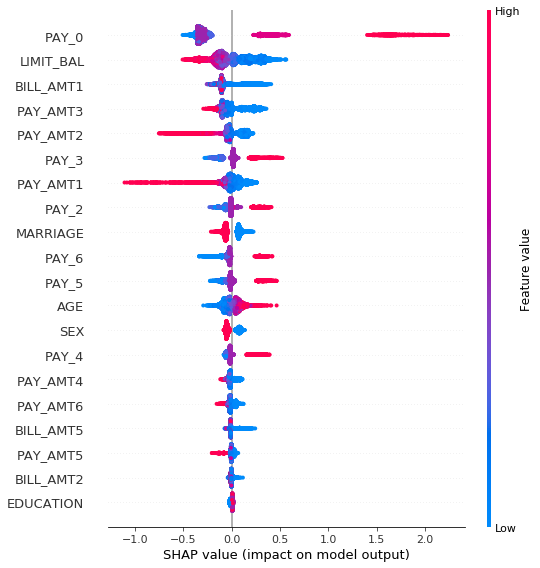

In [56]:
# plot Shapley variable importance summary 
shap.summary_plot(shap_values[:, :-1], test.drop(["DEFAULT_NEXT_MONTH"],axis=1))

####  Display Shapley variable importance summary
The variable importance ranking should be parsimonious with human domain knowledge and reasonable expectations. In this case, `PAY_0` is by far the most important variable. As someone's most recent behavior is a very good indicator of future behavior, this checks out.

### 4. Calculating partial dependence and ICE to validate and explain monotonic behavior

Partial dependence plots are used to view the global, average prediction behavior of a variable under the monotonic model. Partial dependence plots show the average prediction of the monotonic model as a function of specific values of an input variable of interest, indicating how the monotonic GBM predictions change based on the values of the input variable of interest, while taking nonlinearity into consideration and averaging out the effects of all other
input variables. Partial dependence plots enable increased transparency into the monotonic GBM's mechanisms and enable validation and debugging of the monotonic GBM by comparing a variable's average predictions across its domain to known standards and reasonable expectations. Partial dependence plots are described in greater detail in *The Elements of Statistical Learning*, section 10.13: https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf.

Individual conditional expectation (ICE) plots, a newer and less well-known adaptation of partial dependence plots, can be used to create more localized explanations for a single observation of data using the same basic ideas as partial dependence plots. ICE is also a type of nonlinear sensitivity analysis in which the model predictions for a single observation are measured while a feature of interest is varied over its domain. ICE increases understanding and transparency by displaying the nonlinear behavior of the monotonic GBM. ICE also enhances trust, accountability, and fairness by enabling comparisons of nonlinear behavior to human domain knowledge and reasonable expectations. ICE, as a type of sensitivity analysis, can also engender trust when model behavior on simulated or extreme data points is acceptable. A detailed description of ICE is available in this arXiv preprint: https://arxiv.org/abs/1309.6392.

Because partial dependence and ICE are measured on the same scale, they can be displayed in the same line plot to compare the global, average prediction behavior for the entire model and the local prediction behavior for certain rows of data. Overlaying the two types of curves enables analysis of both global and local behavior simultaneously and provides an indication of the trustworthiness of the average behavior represented by partial dependence. (Partial dependence can be misleading in the presence of strong interactions or correlation. ICE curves diverging from the partial dependence curve can be indicative of such problems.) Histograms are also presented with the partial dependence and ICE curves, to enable a rough measure of epistemic uncertainty for model predictions: predictions based on small amounts of training data are likely less dependable.

#### Function for calculating partial dependence
Since partial dependence and ICE will be calculated for several important variables in the GBM model, it's convenient to have a function doing so. It's probably best to analyze partial dependence and ICE for all variables in a model, but only the top three most important input variables will be investigated here. It's also a good idea to analyze partial dependence and ICE on the test data, or other holdout datasets, to see how the model will perform on new data. 
This simple function is designed to return partial dependence when it is called for an entire dataset and ICE when it is called for a single row. The `bins` argument will be used later to calculate ICE values at the same places in an input variable domain that partial dependence is calculated directly below. 

In [0]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        Pandas DataFrame containing partial dependence values.
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        frame.loc[:, xs] = j
        par_dep_i = pd.DataFrame(model.predict(frame))
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame


#### Calculate partial dependence for the most important input variables in the GBM
The partial dependence for `LIMIT_BAL` can be seen to decrease as credit balance limits increase. This finding is aligned with expectations that the model predictions will be monotonically decreasing with increasing `LIMIT_BAL` and parsimonious with well-known business practices in credit lending. Partial dependence for other important values is displayed in plots further below.

In [60]:
par_dep_PAY_0 = par_dep('PAY_0', test.drop(["DEFAULT_NEXT_MONTH"],axis=1), model)         # calculate partial dependence for PAY_0
par_dep_LIMIT_BAL = par_dep('LIMIT_BAL', test.drop(["DEFAULT_NEXT_MONTH"],axis=1), model) # calculate partial dependence for LIMIT_BAL
par_dep_BILL_AMT1 = par_dep('BILL_AMT1', test.drop(["DEFAULT_NEXT_MONTH"],axis=1), model) # calculate partial dependence for BILL_AMT1

# display partial dependence for LIMIT_BAL
par_dep_LIMIT_BAL

,LIMIT_BAL,partial_dependence
0,10000.0,0.279659
1,59500.0,0.246689
2,109000.0,0.224878
3,158500.0,0.214962
4,208000.0,0.211952
5,257500.0,0.210509
6,307000.0,0.208517
7,356500.0,0.199648
8,406000.0,0.191785
9,455500.0,0.191785


#### Helper function for finding percentiles of predictions

ICE can be calculated for any row in the training or test data, but without intimate knowledge of a data source it can be difficult to know where to apply ICE. Calculating and analyzing ICE curves for every row of training and test data set can be overwhelming, even for the example credit card default dataset. One place to start with ICE is to calculate ICE curves at every decile of predicted probabilities in a dataset, giving an indication of local prediction behavior across the dataset. The function below finds and returns the row indices for the maximum, minimum, and deciles of one column in terms of another -- in this case, the model predictions (`p_DEFAULT_NEXT_MONTH`) and the row identifier (`ID`), respectively. 

In [0]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    # create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)
    
    # find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    # find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict


#### Find some percentiles of yhat in the test data
The values for `ID` that correspond to the maximum, minimum, and deciles of `p_DEFAULT_NEXT_MONTH` are displayed below. ICE will be calculated for the rows of the test dataset associated with these `ID` values.

In [66]:
yhat_test

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.741446
1,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,-2.0,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0,0.023761
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.245857
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.234787
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.076015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29974,230000.0,1.0,2.0,1.0,35.0,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
29977,40000.0,1.0,2.0,2.0,47.0,2.0,2.0,3.0,2.0,2.0,2.0,52358.0,54892.0,53415.0,51259.0,47151.0,46934.0,4000.0,0.0,2000.0,0.0,3520.0,0.0,1.0,NaN
29987,360000.0,1.0,1.0,2.0,35.0,-1.0,-1.0,-2.0,-2.0,-2.0,-2.0,2220.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
29992,210000.0,1.0,2.0,1.0,34.0,3.0,2.0,2.0,2.0,2.0,2.0,2500.0,2500.0,2500.0,2500.0,2500.0,2500.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN


In [67]:
# merge GBM predictions onto test data
yhat_test = pd.concat([test.reset_index(), pd.DataFrame(model.predict(test.drop(["DEFAULT_NEXT_MONTH"],axis=1)))],axis=1)
yhat_test = yhat_test.rename(columns={0:'p_DEFAULT_NEXT_MONTH'})

# find percentiles of predictions
percentile_dict = get_percentile_dict('p_DEFAULT_NEXT_MONTH', 'ID', yhat_test)

# display percentiles dictionary
# ID values for rows
# from lowest prediction 
# to highest prediction
percentile_dict

{0: 23477,
 10: 17303,
 20: 7996,
 30: 9204,
 40: 11944,
 50: 12789,
 60: 27040,
 70: 3514,
 80: 11397,
 90: 12936,
 99: 17757}

#### Calculate ICE curve values
ICE values represent a model's prediction for a row of data while an input variable of interest is varied across its domain. The values of the input variable are chosen to match the values at which partial dependence was calculated earlier, and ICE is calculated for the top three most important variables and for rows at each percentile of the test dataset. 

In [0]:
# retreive bins from original partial dependence calculation

bins_PAY_0 = list(par_dep_PAY_0['PAY_0'])
bins_LIMIT_BAL = list(par_dep_LIMIT_BAL['LIMIT_BAL'])
bins_BILL_AMT1 = list(par_dep_BILL_AMT1['BILL_AMT1'])

# for each percentile in percentile_dict
# create a new column in the par_dep frame 
# representing the ICE curve for that percentile
# and the variables of interest
test_n = test.drop(["DEFAULT_NEXT_MONTH"],axis=1).reset_index()

for i in sorted(percentile_dict.keys()):
    
    col_name = 'Percentile_' + str(i)
    
    # ICE curves for PAY_0 across percentiles at bins_PAY_0 intervals
    par_dep_PAY_0[col_name] = par_dep('PAY_0', 
                                    test_n[test_n['ID'] == int(percentile_dict[i])][X],  
                                    model, 
                                    bins=bins_PAY_0)['partial_dependence']
    
    # ICE curves for LIMIT_BAL across percentiles at bins_LIMIT_BAL intervals
    par_dep_LIMIT_BAL[col_name] = par_dep('LIMIT_BAL', 
                                          test_n[test_n['ID'] == int(percentile_dict[i])][X], 
                                          model, 
                                          bins=bins_LIMIT_BAL)['partial_dependence']
    


    # ICE curves for BILL_AMT1 across percentiles at bins_BILL_AMT1 intervals
    par_dep_BILL_AMT1[col_name] = par_dep('BILL_AMT1', 
                                          test_n[test_n['ID'] == int(percentile_dict[i])][X],  
                                          model, 
                                          bins=bins_BILL_AMT1)['partial_dependence']

#### Display partial dependence and ICE for `LIMIT_BAL`
Partial dependence and ICE values for rows at the minimum, maximum and deciles (0%, 10%, 20%, ..., 90%, 99%) of predictions for `DEFAULT_NEXT_MONTH` and at the values of `LIMIT_BAL` used for partial dependence are shown here. Each column of ICE values will be a curve in the plots below. ICE values represent a prediction for a row of test data, at a percentile of interest noted in the column name above, and setting `LIMIT_BAL` to the value of `LIMIT_BAL` at right. Notice that monotonic decreasing prediction behavior for `LIMIT_BAL` holds at each displayed percentile of predicted `DEFAULT_NEXT_MONTH`, helping to validate that the trained GBM predictions are monotonic for `LIMIT_BAL`.

In [69]:
par_dep_LIMIT_BAL

,LIMIT_BAL,partial_dependence,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,10000.0,0.279659,0.017710,0.109711,0.132339,0.111569,0.133364,0.263167,0.274936,0.335844,0.336428,0.629257,0.922201
1,59500.0,0.246689,0.011464,0.096562,0.125872,0.101442,0.126854,0.177702,0.206752,0.242107,0.324046,0.608156,0.881062
2,109000.0,0.224878,0.005992,0.074086,0.092629,0.075265,0.087401,0.164533,0.197863,0.233021,0.308116,0.601457,0.881062
3,158500.0,0.214962,0.004265,0.065973,0.082666,0.064447,0.068675,0.155265,0.189737,0.225953,0.296253,0.598225,0.881062
4,208000.0,0.211952,0.004023,0.065973,0.080524,0.064447,0.066869,0.143649,0.184366,0.222735,0.291457,0.596577,0.879338
5,257500.0,0.210509,0.004023,0.065470,0.079482,0.064447,0.065270,0.142451,0.183851,0.221047,0.290226,0.595503,0.879338
6,307000.0,0.208517,0.003854,0.063332,0.078200,0.063859,0.063509,0.141424,0.183851,0.218256,0.279905,0.595503,0.879338
7,356500.0,0.199648,0.003186,0.055378,0.067393,0.057271,0.055673,0.122251,0.183851,0.200900,0.263366,0.587647,0.878329
8,406000.0,0.191785,0.003186,0.053129,0.064458,0.056138,0.044245,0.122251,0.183851,0.200900,0.254224,0.583385,0.876822
9,455500.0,0.191785,0.003186,0.053129,0.064458,0.056138,0.044245,0.122251,0.183851,0.200900,0.254224,0.583385,0.876822


### 5. Plotting partial dependence and ICE to validate and explain monotonic behavior

Overlaying partial dependence onto ICE in a plot is a convenient way to validate and understand both global and local monotonic behavior. Plots of partial dependence curves overlayed onto ICE curves for several percentiles of predictions for `DEFAULT_NEXT_MONTH` are used to validate monotonic behavior, describe the GBM model mechanisms, and to compare the most extreme GBM behavior with the average GBM behavior in the test data. Partial dependence and ICE plots are displayed for the three most important variables in the GBM: `PAY_0`, `LIMIT_BAL`, and `BILL_AMT1`.

In [0]:
#### Function to plot partial dependence and ICE

def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


#### Partial dependence and ICE plot for `LIMIT_BAL`
The monotonic prediction behavior displayed in the partial dependence, and ICE tables for `LIMIT_BAL` is also visible in this plot. Monotonic decreasing behavior is evident at every percentile of predictions for `DEFAULT_NEXT_MONTH`. Most percentiles of predictions show that sharper decreases in probability of default occur when `LIMIT_BAL` increases just slightly from its lowest values in the test set. However, for the custumers that are most likely to default according to the GBM model, no increase in `LIMIT_BAL` has a strong impact on probabilitiy of default. As mentioned previously, the displayed relationship between credit balance limits and probablility of default is not uncommon in credit lending. As can be seen from the displayed histogram, above ~$NT 500,000 prediction behavior may have been learned from extremely small samples of data. 

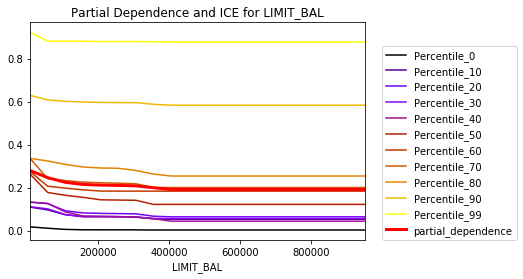

In [71]:
plot_par_dep_ICE('LIMIT_BAL', par_dep_LIMIT_BAL) # plot partial dependence and ICE for LIMIT_BAL

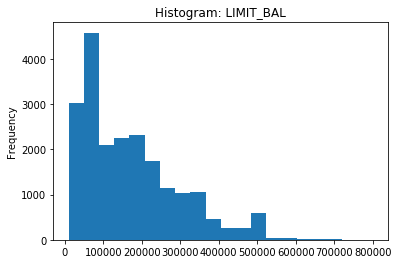

In [72]:
_ = train['LIMIT_BAL'].plot(kind='hist', bins=20, title='Histogram: LIMIT_BAL')

#### Partial dependence and ICE plot for `PAY_0`
Monotonic increasing prediction behavior for `PAY_0` is displayed for all percentiles of model predictions. Predition behavior is different at different deciles, but not abnormal or vastly different from the average prediction behavior represented by the red partial dependence curve. The largest jump in predicted probability appears to occur at `PAY_0 = 2`, or when a customer becomes two months late on their most recent payment. Above `PAY_0 = 3` there are few examples from which the model could learn.

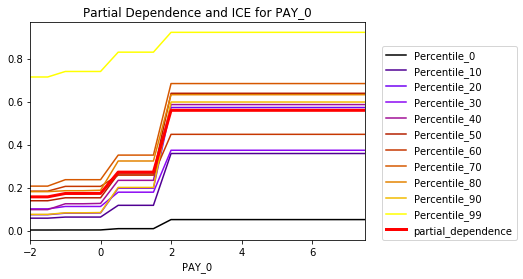

In [73]:
plot_par_dep_ICE('PAY_0', par_dep_PAY_0) # plot partial dependence and ICE for PAY_0

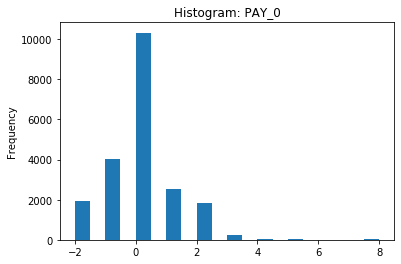

In [74]:
_ = train['PAY_0'].plot(kind='hist', bins=20, title='Histogram: PAY_0')

#### Partial dependence and ICE plot for `BILL_AMT1`
Monotonic decreasing prediction behavior for `BILL_AMT1` is also displayed for all percentiles. This mild decrease in probability of default as most recent bill amount increases could be related to wealthier, big-spending customers taking on more debt but also being able to pay it off reliably. Also, customers with negative bills are more likely to default, potentially indicating charge-offs are being recorded as negative bills. In a mission-critical situation, this issue would require more debugging. Also predictions below \$ NT 0 and above \$ NT 400,000 are based on very little training data.

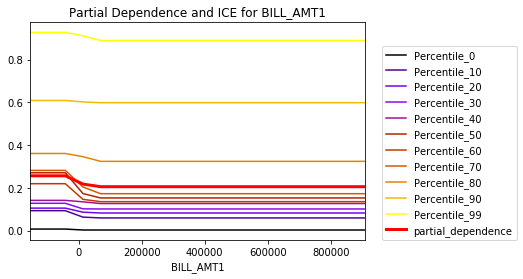

In [75]:
plot_par_dep_ICE('BILL_AMT1', par_dep_BILL_AMT1) # plot partial dependence and ICE for BILL_AMT1

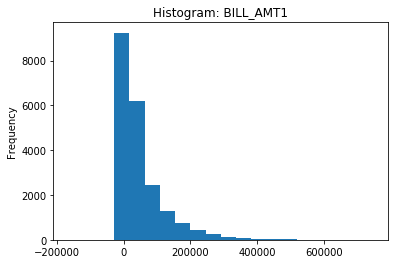

In [76]:
_ = train['BILL_AMT1'].plot(kind='hist', bins=20, title='Histogram: BILL_AMT1')

### 6. Generate reason codes using the Shapley method 
Now that the monotonic behavior of the GBM has been verified and compared against domain knowledge and reasonable expectations, a method called Shapley explanations will be used to calculate the local variable importance for any one prediction: http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions. Shapley explanations are the only possible consistent local variable importance values. (Here consistency means that if a variable is more important than another variable in a given prediction, the more important variable's Shapley value will not be smaller in magnitude than the less important variable's Shapley value.) Very crucially Shapley values also *always* sum to the actual prediction of the XGBoost model. When used in a model-specific context for decision tree models, Shapley values are likely the most accurate known local variable importance method available today. In this notebook, XGBoost itself is used to create Shapley values with the `pred_contribs` parameter to `predict()`, but the `shap` package is also available for other types of models: https://github.com/slundberg/shap. 

The numeric Shapley values in each column are an estimate of how much each variable contributed to each prediction. Shapley contributions can indicate how a variable and its values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are related to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders in the U.S. must provide reasons for automatically rejecting a credit application. Reason codes can be easily extracted from Shapley local variable contribution values by ranking the variables that played the largest role in any given decision.

To find the index corresponding to a particular row of interest later, the index of the `test` DataFrame is reset to begin at 0 and increase sequentially. Without resetting the index, the `test` DataFrame row indices still correspond to the original raw data from which the test set was sampled.

In [0]:
test_n.reset_index(drop=True, inplace=True)

#### Select most risky customer in test data
One person who might be of immediate interest is the most likely to default customer in the test data. This customer's row will be selected and local variable importance for the corresponding prediction will be analyzed.

In [0]:
decile = 99
row = test_n[test_n['ID'] == percentile_dict[decile]]

#### Create a Pandas DataFrame of Shapley values for riskiest customer
The most interesting Shapley values are probably those that push this customer's probability of default higher, i.e. the highest positive Shapley values. Those values are plotted below.

In [0]:
# reset test data index to find riskiest customer in shap_values 
# sort to find largest positive contributions
s_df = pd.DataFrame(shap_values[row.index[0], :][:-1].reshape(23, 1), columns=['Reason Codes'], index=X)
s_df.sort_values(by='Reason Codes', inplace=True, ascending=False)

In [80]:
s_df

,Reason Codes
PAY_0,1.496389
LIMIT_BAL,0.364790
PAY_5,0.314047
PAY_6,0.293947
PAY_4,0.245809
PAY_2,0.217919
BILL_AMT1,0.215625
PAY_3,0.179457
AGE,0.154877
MARRIAGE,0.135945


#### Plot top local contributions as reason codes

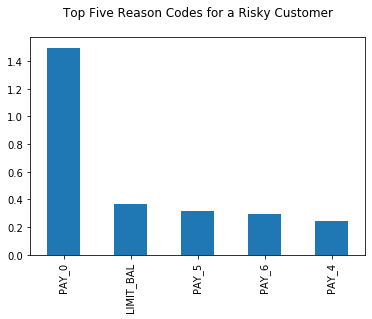

In [81]:
_ = s_df[:5].plot(kind='bar', 
                  title='Top Five Reason Codes for a Risky Customer\n', 
                  legend=False)

For the customer in the test dataset that the GBM predicts as most likely to default, the most important input variables in the prediction are, in descending order, `PAY_0`, `LIMIT_BAL`, `PAY_5`, `PAY_6`, and `PAY_4`.

#### Display customer in question 

The local contributions for this customer appear reasonable, especially when considering her payment information. Her most recent payment was 3 months late and her payment for 6 months and 5 months previous were 7 months late. Also her credit limit was extremely low, so it's logical that these factors would weigh heavily into the model's prediction for default for this customer.

In [82]:
row # helps understand reason codes

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
5399,17757,10000,2,3,1,51,3,2,2,7,7,7,2400,2400,2400,2400,2400,2400,0,0,0,0,0,0


To generate reason codes for the model's decision, the locally important variable and its value are used together. If this customer was denied future credit based on this model and data, the top five Shapley-based reason codes for the automated decision would be:

1. Most recent payment is 3 months delayed.
2. Credit limit is too low: 10,000 $NT. 5th most recent payment is 7 months delayed.
3. 5th most recent payment is 7 months 
4. 6th most recent payment is 7 months delayed.
5. 4th most recent payment is 7 months delayed.

(Of course, credit limits are set by the lender and are used to price-in risk to credit decisions, so using credit limits as reason codes or even in a probability of default model is likely questionable. However, in this small, example data set all input columns were used to generate a better model fit. For a slightly more careful treatment of gradient boosting in the context of credit scoring, please see: https://github.com/jphall663/interpretable_machine_learning_with_python/blob/master/dia.ipynb)

#### Summary

In this notebook, a highly transparent, nonlinear, monotonic GBM classifier was trained to predict credit card defaults and the monotonic behavior of the classifier was analyzed and validated. To do so, Pearson correlation between each input and the target was used to determine the direction for monotonicity constraints for each input variable in the XGBoost classifier. GBM variable importance, partial dependence, and ICE were calculated, plotted, and compared to one another, domain knowledge, and reasonable expectations. Shapley values were then used to explain the model predictions for the single most risky customer in the test set. These techniques should generalize well for many types of business and research problems, enabling you to train a monotonic GBM model and analyze, validate, and explain it to your colleagues, bosses, and potentially, external regulators. 

# LOCO

For nonlinear models, nonlinear dependencies can allow variables to nearly completely replace one another when a variable is dropped and the model is retrained. Hence, the approach of injecting missing values is used to estimate local contributions of input variables for nonlinear models here, as opposed to dropping a variable and retraining the model. LightGBM should have similar functionality to just set as missing.

In [85]:
data

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
0,1,20000,female,university,married,24,2 month delay,2 month delay,pay duly,pay duly,no consumption,no consumption,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,female,university,single,26,pay duly,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,female,university,single,34,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,female,university,married,37,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,male,university,married,57,pay duly,use of revolving credit,pay duly,use of revolving credit,use of revolving credit,use of revolving credit,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,male,high school,married,39,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,male,high school,single,43,pay duly,pay duly,pay duly,pay duly,use of revolving credit,use of revolving credit,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,male,university,single,37,4 month delay,3 month delay,2 month delay,pay duly,use of revolving credit,use of revolving credit,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,male,high school,married,41,1 month delay,pay duly,use of revolving credit,use of revolving credit,use of revolving credit,pay duly,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [88]:
### Lets First Do LOCO
data[X + [y]].describe()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,35.485500,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,9.217904,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,21.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,28.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,34.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,41.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,79.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [0]:
yhat = 'DEFAULT_NEXT_MONTH'

In [0]:
i = "LIMIT_BAL"

In [0]:
test_loco = test.copy()
test_loco[i] = np.nan
preds_loco = model.predict(test_loco)

In [91]:
preds_loco

array([0.77539217, 0.07649864, 0.28123155, ..., 0.32319451, 0.92266493,
       0.13997837])

### Generate reason codes using the LOCO method

In [97]:

print('Calculating LOCO contributions ...')
for k, i in enumerate(X):

    # train and predict with x_i set to missing
    test_loco = test.drop(["DEFAULT_NEXT_MONTH"],axis=1).copy()
    test_loco[i] = np.nan
    preds_loco = model.predict(test_loco)
    
    # create a new, named column for the LOCO prediction
    if k ==0:
      preds2 = pd.DataFrame(preds_loco)
      preds2.columns = [i]
      preds2['DEFAULT_NEXT_MONTH_pred']= model.predict(test.drop(["DEFAULT_NEXT_MONTH"],axis=1))
      preds2['ID'] = test.index
      preds2 = preds2.set_index('ID')
    else:
      preds2[i] = preds_loco
    
    # subtract the LOCO prediction from the original prediction
    preds2[i] = preds2['DEFAULT_NEXT_MONTH_pred'] - preds2[i]
    
    # update progress
    print('LOCO Progress: ' + i + ' (' + str(k+1) + '/' + str(len(X)) + ') ...')
    
# scale contributions to sum to yhat - y_0
print('\nScaling contributions ...')

y_0 = test['DEFAULT_NEXT_MONTH'].mean()
pred_ = preds2['DEFAULT_NEXT_MONTH_pred']
scaler = (pred_ - y_0) / preds2[X].sum(axis=1)
preds2[X] = preds2[X].multiply(scaler, axis=0)   

print('Done.')  

preds2.head()

Calculating LOCO contributions ...
LOCO Progress: LIMIT_BAL (1/23) ...
LOCO Progress: SEX (2/23) ...
LOCO Progress: EDUCATION (3/23) ...
LOCO Progress: MARRIAGE (4/23) ...
LOCO Progress: AGE (5/23) ...
LOCO Progress: PAY_0 (6/23) ...
LOCO Progress: PAY_2 (7/23) ...
LOCO Progress: PAY_3 (8/23) ...
LOCO Progress: PAY_4 (9/23) ...
LOCO Progress: PAY_5 (10/23) ...
LOCO Progress: PAY_6 (11/23) ...
LOCO Progress: BILL_AMT1 (12/23) ...
LOCO Progress: BILL_AMT2 (13/23) ...
LOCO Progress: BILL_AMT3 (14/23) ...
LOCO Progress: BILL_AMT4 (15/23) ...
LOCO Progress: BILL_AMT5 (16/23) ...
LOCO Progress: BILL_AMT6 (17/23) ...
LOCO Progress: PAY_AMT1 (18/23) ...
LOCO Progress: PAY_AMT2 (19/23) ...
LOCO Progress: PAY_AMT3 (20/23) ...
LOCO Progress: PAY_AMT4 (21/23) ...
LOCO Progress: PAY_AMT5 (22/23) ...
LOCO Progress: PAY_AMT6 (23/23) ...

Scaling contributions ...
Done.


,LIMIT_BAL,DEFAULT_NEXT_MONTH,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,-0.087589,0.741446,-0.027768,0.000000,0.000000,0.001757,0.840609,0.036896,-0.159518,-0.031806,-0.034717,-0.000795,-0.006602,-0.001185,0.0,0.000000,0.000000,0.0,0.000000,-0.007187,0.000000,0.000000,0.000000,0.000000
7,-0.074004,0.023761,0.000000,0.000000,-0.014284,0.010908,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.017010,-0.002131,0.0,-0.004393,-0.002042,0.0,-0.031742,-0.028994,-0.026132,-0.004187,-0.001373,-0.000204
9,0.018465,0.245857,0.012581,-0.001143,-0.000000,-0.002951,-0.000000,-0.000000,-0.046886,-0.000000,-0.000000,-0.000000,0.021144,-0.000000,-0.0,-0.000000,0.003358,-0.0,0.005743,-0.000000,0.008711,0.004575,0.001027,0.001883
11,0.005469,0.234787,0.003596,-0.000465,0.002360,-0.002400,-0.000000,-0.000000,-0.014868,-0.000000,-0.000000,0.000998,0.012758,-0.000000,-0.0,-0.000000,0.000925,-0.0,0.002540,-0.000000,0.003220,0.000950,0.000353,-0.000000
12,-0.036447,0.076015,-0.003719,0.000000,-0.009344,0.017796,0.000000,-0.001542,-0.013797,-0.002496,-0.012118,0.021336,-0.015861,-0.002648,0.0,-0.004111,-0.002296,0.0,-0.026130,-0.011256,-0.022017,-0.005314,0.000000,-0.013373




The numeric LOCO values in each column are an estimate of how much each variable contributed to each prediction. LOCO can indicate how a variable and its values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are related to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders in the U.S. must provide reasons for automatically rejecting a credit application. Reason codes can be easily extracted from LOCO local variable contribution values by simply ranking the variables that played the largest role in any given decision.


In [102]:
risky_loco

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
ID,,,,,,,,,,,,,,,,,,,,,,,
17757,0.0,-0.050616,0.0,0.0,0.080526,0.515178,0.008199,0.003268,0.055602,0.079242,0.095613,-0.013842,0.0,0.0,0.0,-0.049255,-0.021064,0.0,0.0,0.0,0.0,0.0,0.0


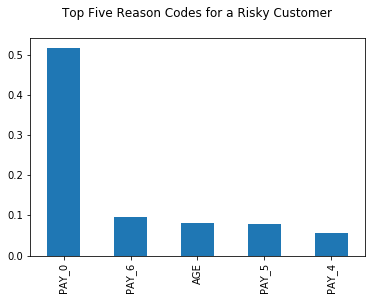

In [104]:
# select single customer
# convert to Pandas
# drop prediction and row ID

risky_loco = preds2[preds2.index == int(percentile_dict[99])].drop(["DEFAULT_NEXT_MONTH"], axis=1)   

# transpose into column vector and sort        
risky_loco = risky_loco.T.sort_values(by=17757, ascending=False)[:5]

# plot
_ = risky_loco.plot(kind='bar', 
                    title='Top Five Reason Codes for a Risky Customer\n', 
                    legend=False)

In [106]:
data['ID']

0            1
1            2
2            3
3            4
4            5
         ...  
29995    29996
29996    29997
29997    29998
29998    29999
29999    30000
Name: ID, Length: 30000, dtype: int64

In [107]:
def recode_cc_data(frame):
    
    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 
    
    Args:
        frame: Pandas DataFrame version of UCI credit card default data.
        
    Returns: 
        H2OFrame with recoded values.
        
    """
    
    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}
    
    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            
                
    return frame

data = recode_cc_data(data)

17757

In [111]:
data[data["ID"]==percentile_dict[99]] # helps understand reason codes

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
17756,17757,10000,female,high school,married,51,3 month delay,2 month delay,2 month delay,7 month delay,7 month delay,7 month delay,2400,2400,2400,2400,2400,2400,0,0,0,0,0,0,1




To generate reason codes for the model's decision, the locally important variable and its value are used together. If this customer was denied future credit based on this model and data, the top five LOCO-based reason codes for the automated decision would be:

    Most recent payment is 3 months delayed.
    6th most recent payment is 4 months delayed.
    3rd most recent payment is 3 months delayed.
    5th most recent payment is 2 months delayed.
    Customer age is 59.

(Of course, in many places, variables like AGE and SEX cannot, and should not, be used in credit lending or other high-stakes decisions. For a slightly more careful treatment of GBM in a fair lending context, see: https://github.com/jphall663/interpretable_machine_learning_with_python/blob/master/dia.ipynb)


For LOCO you should in fact run an ensemble model to give you the best results. 

In [0]:
### bottom - https://nbviewer.jupyter.org/github/jphall663/interpretable_machine_learning_with_python/blob/master/dt_surrogate_loco.ipynb


##

# Disparate Impact Analysis

Assess if your machine learning model is treating different groups of people similarly or differently

Fairness is an incredibly important, but highly complex entity. So much so that leading scholars have yet to agree on a strict definition. However, there is a practical way to discuss and handle observational fairness, or how your model predictions affect different groups of people. This procedure is often known as disparate impact analysis (DIA). DIA is far from perfect, as it relies heavily on user-defined thresholds and reference levels for disparity and does not attempt to remediate disparity or provide information on sources of disparity, but it is a fairly straightforward method to quantify your model’s behavior across sensitive demographic segments or other potentially interesting groups of observations. DIA is also an accepted, regulation-compliant tool for fair-lending purposes in the U.S. financial services industry. If it’s good enough for multibillion-dollar credit portfolios, it’s probably good enough for your project.

This example DIA notebook starts by training a constrained, monotonic gradient boosting machine (GBM) classifier on the UCI credit card default data using the popular open source library, h2o. A probability cutoff for making credit decisions is selected by maximizing the F1 statistic and confusion matrices are generated to summarize the GBM’s decisions across male and female customers. A basic DIA procedure is then conducted using the information stored in the confusion matrices then several traditional fair lending measures are calculated.

Because DIA really only considers groups of people, it's important to pair DIA with constrained models that can't treat similar people too differently. When using complex models with DIA, it's also important to look for any local, or individual, dicrimination that would not be flagged in the group quantities.

For an excellent and free reference on the topics of fairness and machine learning be sure to follow the book being written by Solon Barocas, Moritz Hardt and Arvind Narayanan: https://fairmlbook.org/.

#### Select a Probability Cutoff by Maximizing F1 Statistic

unction to calculate PR-AUC Curve

Predictive models often produce probabilities, not decisions. So to make a decision with a model-generated predicted probability for any one customer, you must specify a numeric cutoff above which we say a customer will default and below which we say they will not default. Cutoffs play a crucial role in DIA as they impact the underlying measurements used to calculate diparity. In fact, tuning cutoffs carefully is a potential remdiation tactic for any discovered disparity. There are many accepted ways to select a cutoff (besides simply using 0.5) and in this notebook the cutoff will be selected by striking a balance between the model's recall (true positive rate) and it's precision using the F1 statistic. Using precision and recall to select a cutoff is sometimes seen as more robust to imbalanced data than the standard ROC approach. Maximizing F1 typically results in a good balance between sensitivity and precision.

In [0]:
    preds_loco = model.predict(test_loco)
    
    # create a new, named column for the LOCO prediction
    if k ==0:
      preds2 = pd.DataFrame(preds_loco)
      preds2.columns = [i]
      preds2['DEFAULT_NEXT_MONTH']= model.predict(test.drop(["DEFAULT_NEXT_MONTH"],axis=1))
      preds2['ID'] = test.index
      preds2 = preds2.set_index('ID')

In [0]:
preds= model.predict(test.drop(["DEFAULT_NEXT_MONTH"],axis=1))
preds_frame = recode_cc_data(test.copy())
preds_frame['DEFAULT_NEXT_MONTH_pred'] = preds 


In [0]:
def get_prauc(frame, y, yhat, pos=1, neg=0, res=0.01):
    
    """ Calculates precision, recall, and f1 for a pandas dataframe of y and yhat values.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.
    
    Returns:
        Pandas dataframe of precision, recall, and f1 values. 
    """
    
    frame_ = frame.copy(deep=True) # don't destroy original data
    dname = 'd_' + str(y) # column for predicted decisions
    eps = 1e-20 # for safe numerical operations
    
    # init p-r roc frame
    prauc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])
    
    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
        
        # calculate confusion matrix values
        tp = frame_[(frame_[dname] == pos) & (frame_[y] == pos)].shape[0]
        fp = frame_[(frame_[dname] == pos) & (frame_[y] == neg)].shape[0]
        tn = frame_[(frame_[dname] == neg) & (frame_[y] == neg)].shape[0]
        fn = frame_[(frame_[dname] == neg) & (frame_[y] == pos)].shape[0]
        
        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))
        
        # add new values to frame
        prauc_frame = prauc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1}, 
                                          ignore_index=True)
    
    # housekeeping
    del frame_
    
    return prauc_frame
        
prauc_frame = get_prauc(preds_frame, 'DEFAULT_NEXT_MONTH', 'DEFAULT_NEXT_MONTH_pred')

##### Select Best Cutoff

In [140]:
best_cut = prauc_frame.loc[prauc_frame['f1'].idxmax(), 'cutoff'] # Find cutoff w/ max F1
### !!! UNCOMMENT LINES BELOW TO REMEDIATE MINOR FAIRNESS ISSUES !!! ###
# best_cut = 0.3  # min threshold with overall fairness
# best_cut = 0.46 # max accuracy
# best_cut = 0.35 # max MCC
print('%.2f' % best_cut)

0.25



#### Plot PR-AUC Curve

An area under the curve for precision and recall (PR-AUC) plot is a typical way to visualize recall and precision for a predictive model. The F1 statistic is the harmonic mean of recall and precision, and we can visualize where F1 is maximized on with the AUC-PR curve.


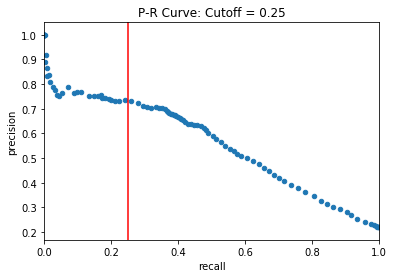

In [141]:
# Plot P-R AUC w/ best cutoff
title_ = 'P-R Curve: Cutoff = ' + str(best_cut)
ax = prauc_frame.plot(x='recall', y='precision', kind='scatter', title=title_, xlim=[0,1])
_ = ax.axvline(best_cut, color='r')

##### Report Raw Confusion Matrices¶

The basic DIA procedure in this notebook is based on measurements found commonly in confusion matrices, so confusion matrices are calculated as a precursor to DIA and to provide a basic summary of the GBM's behavior in general and across men and women.


In [142]:


def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, default None.
        level: Value of by variable to slice frame before creating confusion matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5. 

    Returns:
        Confusion matrix as pandas dataframe. 
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19
    
    # output results
    if by is None:
        print('Confusion matrix:')
    else:
        print('Confusion matrix by ' + by + '=' + level)
    
    return cm_frame
    
    
get_confusion_matrix(preds_frame, 'DEFAULT_NEXT_MONTH', 'DEFAULT_NEXT_MONTH_pred', cutoff=best_cut)



Confusion matrix:


,actual: 1,actual: 0
predicted: 1,1237,1291
predicted: 0,749,5777




The general confusion matrix shows that the GBM is more accurate than not because the true positive and true negative cells contain the largest values by far. But the GBM seems to make a larger number of type II errors or false negative predictions. False negatives can be a disparity issue, because for complex reasons, many credit scoring and other models tend to over-estimate the likelihood of non-reference groups - typically people other than white males - to default. This is both a sociological fairness problem and a financial problem if an unpriviledged group is not recieving the credit they deserve, in favor of undeserving white males. Deserving people miss out on potentially life-changing credit and lenders incur large write-off costs.



Report confusion matrices by SEX

The only values for SEX in the dataset are female and male.


In [143]:
sex_levels = list(preds_frame['SEX'].unique())
sex_levels

['female', 'male']

Confusion matrix for SEX = male

In [146]:


male_cm = get_confusion_matrix(preds_frame, 'DEFAULT_NEXT_MONTH', 'DEFAULT_NEXT_MONTH_pred', by='SEX', level='male', cutoff=best_cut)
male_cm



Confusion matrix by SEX=male


,actual: 1,actual: 0
predicted: 1,553,567
predicted: 0,290,2182


Confusion matrix for SEX = female

In [147]:
female_cm = get_confusion_matrix(preds_frame, 'DEFAULT_NEXT_MONTH', 'DEFAULT_NEXT_MONTH_pred', by='SEX', level='female', cutoff=best_cut)
female_cm

Confusion matrix by SEX=female


,actual: 1,actual: 0
predicted: 1,684,724
predicted: 0,459,3595


### Disparate Impact Analysis (DIA)



To perform the following basic DIA many different values from the confusion matrices reflecting different prediction behavior are calculated. These metrics essentially help us understand the GBM's overall performance and how it behaves when predicting:

    Default correctly
    Non-default correctly
    Default incorrectly (type I errors)
    Non-default incorrectly (type II errors)

In a real-life lending scenario, type I errors essentially amount to false accusations of financial impropriety and type II errors result in awarding loans to undeserving customers. Both types of errors can be costly to the lender too. Type I errors likely result in lost interest and fees. Type II errors often result in write-offs.


Dictionary of metrics used to assess disparity and parity

In [0]:
# represent metrics as dictionary for use later
metric_dict = {

#### overall performance
'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much default actually happens for this group
#'Adverse Impact': '(tp + fp) / (tp + tn + fp + fn)', # how often the model predicted default for each group   
'Accuracy':       '(tp + tn) / (tp + tn + fp + fn)', # how often the model predicts default and non-default correctly for this group

#### predicting default will happen
# (correctly)
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default              
'Precision':          'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default

#### predicting default won't happen
# (correctly)
'Specificity':              'tn / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default  

#### analyzing errors - type I
# false accusations 
'False Positive Rate':  'fp / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

#### analyzing errors - type II
# costly ommisions
'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default
'False Omissions Rate':'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default
}  

Utility function to translate metrics into Pandas statements

In [0]:
# small utility function
# translates abbreviated metric expressions into executable Python statements

def cm_exp_parser(expression):
    
    # tp | fp       cm_dict[level].iat[0, 0] | cm_dict[level].iat[0, 1]
    # -------  ==>  --------------------------------------------
    # fn | tn       cm_dict[level].iat[1, 0] | cm_dict[level].iat[1, 1]

    expression = expression.replace('tp', 'cm_dict[level].iat[0, 0]')\
                           .replace('fp', 'cm_dict[level].iat[0, 1]')\
                           .replace('fn', 'cm_dict[level].iat[1, 0]')\
                           .replace('tn', 'cm_dict[level].iat[1, 1]')

    return expression

Calculate and report metrics
This nested loop calculates all the metrics defined above for men and women.

In [150]:


# initialize dict of confusion matrices and corresponding rows of dataframe
cm_dict = {'male': male_cm, 
           'female': female_cm} 

metrics_frame = pd.DataFrame(index=sex_levels) # frame for metrics

# nested loop through:
# - sex levels
# - metrics 
for level in sex_levels:
    for metric in metric_dict.keys():
              
        # parse metric expressions into executable pandas statements
        expression = cm_exp_parser(metric_dict[metric])

        # dynamically evaluate metrics to avoid code duplication
        metrics_frame.loc[level, metric] = eval(expression)  

# display results                
metrics_frame

# Prevalance - how much default actually happend

# In this sample 


,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
female,0.209264,0.783413,0.598425,0.485795,0.832369,0.886778,0.167631,0.514205,0.401575,0.113222
male,0.234688,0.761414,0.655991,0.493750,0.793743,0.882686,0.206257,0.506250,0.344009,0.117314


The False Positive Rate is high for men, that means that the model predicted a lot of men would default who did in fact not default. 


Plot false omissions rate by SEX

Because the confusion matrices indicated there might be a problem with non-default predictions, false omissions rate will be examined closely. False omissions measures how many customers the model predicted incorrectly would not default, out of the customers in the group the model predicted would not default. (Of course other metrics are important from a fairness and business perspective. For an excellent in-depth discussion and example regarding numerous disparity metrics, see: https://github.com/dssg/aequitas/blob/master/docs/source/examples/compas_demo.ipynb)


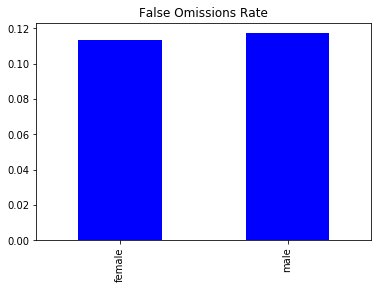

In [151]:
## Too similar to do anything about it 
_ = metrics_frame['False Omissions Rate'].plot(kind='bar', color='b', title='False Omissions Rate')


Calculate and report disparity

To calculate disparity we compare the confusion matrix for each sex to the metrics for a user-defined reference level and to user-defined thresholds. In this case, we take the class of people who seem most priviledged as the reference level, i.e. SEX = male. (Usually the reference level would be race = white or sex = male.) According to the four-fifths rule (https://en.wikipedia.org/wiki/Disparate_impact#The_80%_rule) thresholds are set such that metrics 20% lower or higher than the reference level metric will be flagged as disparate. Technically, the four-fifths rule only applies to the adverse impact ratio, discussed further below, but it will be applied to all other displayed metrics as a rule of thumb.


In [152]:


ref_level = 'male' # user-defined reference level

parity_threshold_low = 0.8    # user-defined low threshold value
parity_threshold_hi = 1.25    # user-defined high threshold value

# init frame to store disparity measures
disp_frame = pd.DataFrame(index=sex_levels)

# compare all metrics to reference level
disp_frame = metrics_frame/metrics_frame.loc[ref_level, :]

# change column names
disp_frame.columns=[col + ' Disparity' for col in metrics_frame.columns]

# small utility function to format pandas table output
def disparate_red(val):
    
    color = 'blue' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color 

# display results
disp_frame.style.applymap(disparate_red)



,Prevalence Disparity,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
female,0.891668,1.02889,0.912247,0.98389,1.04866,1.00464,0.812731,1.01571,1.16734,0.965116
male,1,1,1,1,1,1,1,1,1,1


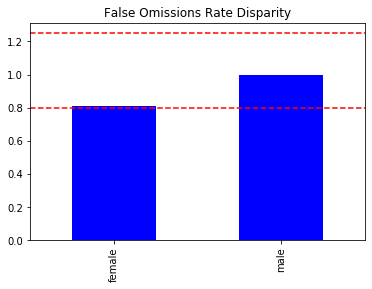

In [153]:
## The model is a bit hard on predicting male defaults vs female defaults. 

ax = disp_frame['False Positive Rate Disparity'].plot(kind='bar', color='b', title='False Omissions Rate Disparity')
_ = ax.axhline(parity_threshold_low, color='r', linestyle='--')
_ = ax.axhline(parity_threshold_hi, color='r', linestyle='--')





Assess and report parity

A binary indication of parity for metrics is reported by simply checking whether disparity values are within the user-defined thresholds. Further parity indicators are defined as combinations of other disparity values:

    Type I Parity: Both FDR Parity and FPR Parity
    Type II Parity: Both FOR Parity and FNR Parity
    Equalized Odds: Both FPR Parity and TPR Parity
    Supervised Fairness: Both Type I and Type II Parity
    Overall Fairness: Fairness across all metrics



In [154]:
# parity checks
# low_threshold (0.8) < *_metric/white_metric < (high_threshold) 1.25 => parity, else disparity 

# init frame for parity
par_frame = pd.DataFrame(index=sex_levels, 
                         columns=[col + ' Parity' for col in metrics_frame.columns])
# nested loop through: 
# - races
# - disparity metrics
for i, _ in enumerate(sex_levels):
    for j, _ in enumerate(par_frame.columns):
        par_frame.iat[i, j] = (parity_threshold_low < disp_frame.iat[i, j] < parity_threshold_hi)

# add overall parity checks
# Type I Parity: Fairness in both FDR Parity and FPR Parity
# Type II Parity: Fairness in both FOR Parity and FNR Parity
# Equalized Odds: Fairness in both FPR Parity and TPR Parity
# Supervised Fairness: Fairness in both Type I and Type II Parity
# Overall Fairness: Fairness across all parities for all metrics
par_frame['Type I Parity'] = (par_frame['False Discovery Rate Parity']) & (par_frame['False Positive Rate Parity'])
par_frame['Type II Parity'] = (par_frame['False Omissions Rate Parity']) & (par_frame['False Negative Rate Parity'])
par_frame['Equalized Odds'] = (par_frame['False Positive Rate Parity']) & (par_frame['True Positive Rate Parity'])
par_frame['Supervised Fairness'] = (par_frame['Type I Parity']) & (par_frame['Type II Parity'])
par_frame['Overall Fairness'] = par_frame.all(axis='columns')
par_frame.loc['all', :] = par_frame.all(axis='index')
    
# small utility function to format pandas table output    
def color_false_red(val):

    color = 'red' if not val else 'blue'
    return 'color: %s' % color 
    
par_frame.style.applymap(color_false_red)

,Prevalence Parity,Accuracy Parity,True Positive Rate Parity,Precision Parity,Specificity Parity,Negative Predicted Value Parity,False Positive Rate Parity,False Discovery Rate Parity,False Negative Rate Parity,False Omissions Rate Parity,Type I Parity,Type II Parity,Equalized Odds,Supervised Fairness,Overall Fairness
female,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
male,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
all,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


To address any bias, users could tune the GBM cutoff or regularization, could try new methods for reweighing data prior to model training, try new modeling methods specifically designed for fairness, or post-process the decisions. Checkout the IBM AIF360 package for some of these techniques: http://aif360.mybluemix.net/. Before attempting remediation here, more traditional fair lending measures will be assessed and, local, or individual, fairness will also be investigated.

#### Traditional Fair Lending Measures

Along with adverse impact ratio (AIR), several measures have long-standing legal precedence in fair lending, including marginal effect and standardized mean difference. These measures are calculated and discussed here.
Simple function to calculate adverse impact ratio (AIR)

AIR is perhaps the most well-known discrimination measure. It was first delineated by the U.S. Equal Employment Opportunity Commission (EEOC) and AIR is associated with the convenient 4/5ths, or 0.8, cutoff threshold. AIR values below 0.8 can be considered evidence of illegal discrimination in many lending or employment scenarios in the U.S.


In [155]:
 def air(reference, protected):

    """ Calculates the adverse impact ratio as a quotient between protected and 
        reference group acceptance rates: protected_prop/reference_prop. 
        Prints intermediate values. Tightly coupled to cm_dict. 
    
    Args:
        reference: name of reference group in cm_dict as a string.
        protected: name of protected group in cm_dict as a string.

    Returns:
        AIR as a formatted string. 
        
    """

    # reference group summary
    reference_accepted = float(cm_dict[reference].iat[1,0] + cm_dict[reference].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference].sum().sum())
    reference_prop = reference_accepted/reference_total
    print(reference.title() + ' proportion accepted: %.3f' % reference_prop)
    
    # protected group summary
    protected_accepted = float(cm_dict[protected].iat[1,0] + cm_dict[protected].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected].sum().sum())
    protected_prop = protected_accepted/protected_total
    print(protected.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    return 'Adverse impact ratio: %.3f' % (protected_prop/reference_prop)

print(air('male', 'female'))

Male proportion accepted: 0.688
Female proportion accepted: 0.742
Adverse impact ratio: 1.078


Typical desirable ranges of AIR are above the 0.8 marker set by the 4/5ths rule. Here we see an almost ideal result where the protected and reference groups have very similar acceptance rates and AIR is near 1, slightly in favour of women.


##### Simple function to calculate marginal effect¶

Marginal effect describes the difference between the percent of the reference group awarded a loan and the percent of the protected group awarded a loan under a model.


In [156]:
def marginal_effect(reference, protected):

    """ Calculates the marginal effect as a percentage difference between a reference and 
        a protected group: reference_percent - protected_percent. Prints intermediate values. 
        Tightly coupled to cm_dict. 
    
    Args:
        reference: name of reference group in cm_dict as a string.
        protected: name of protected group in cm_dict as a string.

    Returns:
        Marginal effect as a formatted string. 
        
    """
    
    # reference group summary
    reference_accepted = float(cm_dict[reference].iat[1,0] + cm_dict[reference].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference].sum().sum())
    reference_percent = 100*(reference_accepted/reference_total)
    print(reference.title() + ' accepted: %.2f%%' % reference_percent)
    
    # protected group summary
    protected_accepted = float(cm_dict[protected].iat[1,0] + cm_dict[protected].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected].sum().sum())
    protected_percent = 100*(protected_accepted/protected_total)
    print(protected.title() + ' accepted: %.2f%%' % protected_percent)
    
    # return marginal effect
    return 'Marginal effect: %.2f%%' % (reference_percent - protected_percent)

print(marginal_effect('male', 'female'))

Male accepted: 68.82%
Female accepted: 74.22%
Marginal effect: -5.40%


Given that the marginal effect is negative, indicating that a higher percentage of individuals in the protected group were awarded a loan than in the reference group, this value would likely not indicate a discrimination problem in most scenarios. The magnitude of the marginal effect is also relatively small, another sign that discrimination concerning SEX is low under the model. Generally, larger marginal effects may be tolerated in newer credit products, whereas smaller marginal effects are expected in established credit products.


##### Standardized mean difference

The standardized mean difference (SMD), i.e. Cohen's D, is the mean value of the prediction for the protected group minus the mean prediction for the reference group, all divided by the standard deviation of the prediction. Like AIR, SMD has some prescribed thresholds: 0.2, 0.5, and 0.8 for small, medium, and large differences, respectively. The standardized mean difference can also be used on continuous values like credit limits or loan amounts.


In [158]:
def smd(frame, yhat, j, reference, protected):
    
    """ Calculates standardized mean difference between a protected and reference group:
    (mean(yhat | j=protected) - mean(yhat | j=reference))/sigma(yhat). 
    Prints intermediate values. 
    
    Args:
        frame: Pandas dataframe containing j and predicted (yhat) values.
        yhat: Name of predicted value column.
        j: name of demographic column containing reference and protected group labels. 
        reference: name of reference group in j.
        protected: name of protected group in j. 

    Returns:
       Standardized mean difference as a formatted string.
       
    """
    
    # yhat mean for j=reference
    reference_yhat_mean = frame[frame[j] == reference][yhat].mean()
    print(reference.title() + ' mean yhat: %.2f' % reference_yhat_mean)
    
    #yhat mean for j=protected 
    protected_yhat_mean = frame[frame[j] == protected][yhat].mean()
    print(protected.title() + ' mean yhat: %.2f' % protected_yhat_mean)
    
    # std for yhat
    sigma = frame[yhat].std()
    print(yhat.title() + ' std. dev.:  %.2f' % sigma)
    
    return 'Standardized Mean Difference: %.2f' % ((protected_yhat_mean - reference_yhat_mean)/sigma)
    
print(smd(preds_frame, 'DEFAULT_NEXT_MONTH_pred', 'SEX', 'male', 'female'))

Male mean yhat: 0.24
Female mean yhat: 0.21
Default_Next_Month_Pred std. dev.:  0.20
Standardized Mean Difference: -0.15




For this model, in the test set, men receive a higher average probability of default than do women. This difference is evident even after standardizing with the standard deviation of the predictions. However, the difference is quite small, below the 0.2 threshold for a small difference. SMD also points to low disparity between men and women under this model.


#### Investigate Individual Disparity

In nonlinear models, similar people can be treated differenly by the model, so even if the model is mostly fair for most kinds of people, there could still be people the model treated unfairly. This could occur for multiple reasons, including the functional form of the learned model or because different variables are combined by the model to represent strong signals. If a variable is important in a dataset, model, or problem domain it's likely that a nonlinear model will find combinations of other variables to act as proxies for the problematic variable -- potentially even different combinations for different rows of data! So by simply testing for group fairness, you may miss instances of individual discrimination.



Augment predictions with decisions and logloss residuals for women with false positive predictions

In this notebook, residuals for false positive predictions for women will be examined in an attempt to locate any individual instances of model discrimination. These are women who the model said would default, but they did not default. So they may have experienced some discrimination under the model.


In [163]:
test_yhat_female[yhat]

ID
1        1
9        0
11       0
12       0
19       0
        ..
29160    0
29161    0
29162    1
29170    1
29179    0
Name: DEFAULT_NEXT_MONTH, Length: 5462, dtype: int64

In [172]:
test_yhat_female[yhat]

ID
1        1
9        0
11       0
12       0
19       0
        ..
29160    0
29161    0
29162    1
29170    1
29179    0
Name: DEFAULT_NEXT_MONTH, Length: 5462, dtype: int64

In [177]:
test_yhat_female["d_DEFAULT_NEXT_MONTH"]

ID
1        1
9        0
11       0
12       0
19       0
        ..
29160    0
29161    0
29162    1
29170    1
29179    0
Name: d_DEFAULT_NEXT_MONTH, Length: 5462, dtype: int64

In [178]:
y

'DEFAULT_NEXT_MONTH'

In [0]:
test_yhat_female = preds_frame[preds_frame['SEX'] == 'female'].copy(deep=True)

yhat = 'DEFAULT_NEXT_MONTH_pred'
y = 'DEFAULT_NEXT_MONTH'
test_yhat_female['d_DEFAULT_NEXT_MONTH'] = 0
test_yhat_female.loc[test_yhat_female[yhat] > best_cut, 'd_DEFAULT_NEXT_MONTH'] = 1

test_yhat_female['r_DEFAULT_NEXT_MONTH'] = -test_yhat_female[y]*np.log(test_yhat_female[yhat]) -\
                       (1 - test_yhat_female[y])*np.log(1 - test_yhat_female[yhat]) 
    
test_yhat_female_fp = test_yhat_female[(test_yhat_female[y] == 0) &\
                                       (test_yhat_female['d_DEFAULT_NEXT_MONTH'] == 1)]

No handles with labels found to put in legend.


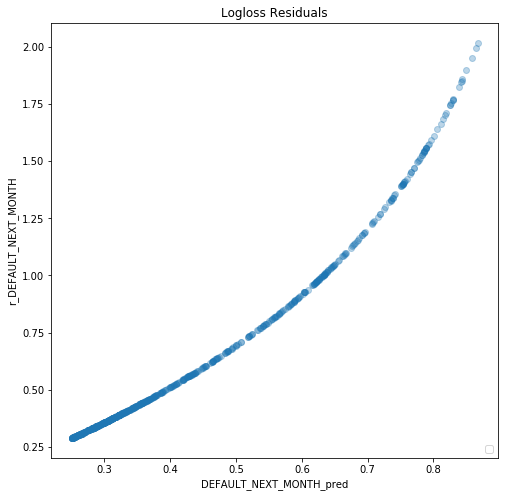

In [183]:
# initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))         

ax_.plot(test_yhat_female_fp[yhat],
         test_yhat_female_fp['r_DEFAULT_NEXT_MONTH'],
         marker='o', linestyle='', alpha=0.3)

# annotate plot
_ = plt.xlabel(yhat)
_ = plt.ylabel('r_DEFAULT_NEXT_MONTH')
_ = ax_.legend(loc=4)
_ = plt.title('Logloss Residuals')

In [184]:
test_yhat_female_fp.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=False).head(n=3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,DEFAULT_NEXT_MONTH_pred,d_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
5916,110000,female,graduate school,married,41,2 month delay,2 month delay,7 month delay,7 month delay,7 month delay,7 month delay,150,150,150,150,150,150,0,0,0,0,0,0,0,0.867113,1,2.018254
27651,20000,female,high school,married,54,2 month delay,use of revolving credit,use of revolving credit,2 month delay,2 month delay,2 month delay,14381,16174,18210,19335,19715,20249,2350,2300,1721,1000,1000,1000,0,0.864284,1,1.997194
10918,200000,female,high school,married,54,6 month delay,5 month delay,4 month delay,3 month delay,2 month delay,2 month delay,110185,107665,104686,102549,101400,0,0,0,0,0,0,0,0,0.857903,1,1.951249




Looking at the top 3 highest residual predictions, it's clear these were customers with a horrible payment track record that somehow were able to make a last-minute payment. Although it's not possible to say they were not discrimated against by the model, it seems very clear that the model was justified to issue default predictions for these customers.



#### Adverse Action Notices

Anyone that is denied further credit due to this model in the U.S. must be given reasons why. Shapley values provide a mechanism to rank the contributions of input variables to any given model decision and may be suitable for adverse action notice generation. Because the highest residual false positive female seems like a probable candidate to be rejected for further credit at some point, Shapley values can be used to say why according to this model.


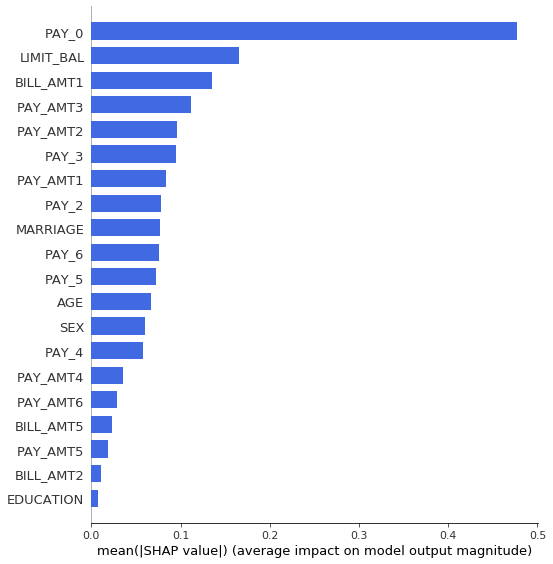

In [188]:
contributions_matrix = model.predict(test,pred_contrib=True)
shap_values = contributions_matrix[:,:-1]
shap.summary_plot(shap_values, X, plot_type='bar', color='royalblue')

Sum of Shapley contributions and bias: -0.05145796754564835
Model prediction in margin space: 1.8756679117354085


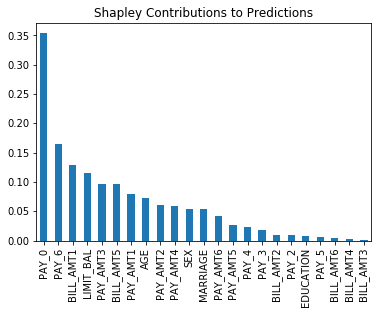

In [190]:
# select highest residual female false positive
row = test_yhat_female_fp.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=False).head(n=1)

# search for her index in shap_values array
# create Pandas DataFrame and plot
s_df = pd.DataFrame(shap_values[row.index[0], :].reshape(len(X), 1), columns=['Reason Codes'], index=X).abs()
_ = s_df.sort_values(by='Reason Codes', ascending=False).plot(kind='bar', legend=False, 
                                                              title='Shapley Contributions to Predictions')

# check that Shapley is locally accurate
print('Sum of Shapley contributions and bias:', s_df.sum()[0] + contributions_matrix[0, -1])
print('Model prediction in margin space:', np.log(row[yhat].values/(1 - row[yhat].values))[0])



Combining the Shapley values with the individual's data values allows ranked reasons to be given for denial of credit:

    Two months late on most recent payment
    Seven months late on 6th most recent payment


Because monotonicity contraints were used during model training, these reasons should be consistent across all denial decisions meaning that no one who was denied credit would have a better value for an input variable than someone who was granted credit.



Examine low logloss residual individuals¶

Given that high-residual individuals were not clearly discriminated against, their low-residual counter parts could be interesting to investigate next.


In [192]:


top = test_yhat_female_fp.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=True).head(n=150);top



,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,DEFAULT_NEXT_MONTH_pred,d_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
22913,270000,female,other,married,33,no consumption,no consumption,no consumption,no consumption,no consumption,no consumption,0,0,1205,0,0,0,0,1205,0,0,0,0,0,0.250383,1,0.288193
25509,120000,female,graduate school,single,26,1 month delay,pay duly,pay duly,pay duly,pay duly,no consumption,-93,936,0,680,0,0,1029,0,680,0,0,1381,0,0.250443,1,0.288273
23727,330000,female,high school,married,50,pay duly,pay duly,no consumption,no consumption,no consumption,pay duly,2064,0,0,0,0,324,0,0,0,0,324,0,0,0.250507,1,0.288359
19800,150000,female,high school,married,40,no consumption,no consumption,no consumption,no consumption,no consumption,no consumption,0,0,0,0,0,4095,0,0,0,0,4095,0,0,0.250728,1,0.288653
78,300000,female,graduate school,married,45,pay duly,pay duly,pay duly,pay duly,pay duly,pay duly,291,291,291,291,291,291,291,291,291,291,291,291,0,0.250795,1,0.288742
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12493,20000,female,high school,married,33,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,2909,3537,4120,3802,3484,3152,1224,1197,269,269,261,227,0,0.284864,1,0.335283
9977,110000,female,graduate school,single,32,1 month delay,pay duly,use of revolving credit,use of revolving credit,use of revolving credit,no consumption,0,1670,11693,7903,-18,-18,1670,10200,0,0,0,0,0,0.285310,1,0.335906
28138,230000,female,high school,married,36,1 month delay,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,232115,225086,222286,222884,220876,221496,22,9005,9037,7519,8018,8100,0,0.285368,1,0.335987


Examing the low-residual false positives, it can be seen that perhaps the F1-selected cutoff is a bit too conservative. Many women just above the cutoff have missed 0-2 payments, and only been late 1-2 months on the few payments they missed, if any. This potential bias problem can be remediated by increasing the cutoff in cell 14.

In [193]:
### What would be interesting is to see who is near the cutoff. 
top["SEX"].value_counts()

female    150
Name: SEX, dtype: int64


Conclusion

This notebook outlines a basic approach to DIA (and over-generalizes that phrase). In a complex, real-world machine learning project the hard-to-define phenomenas of sociological bias and unfairness can materialize in many ways and from many different sources. Although far from a flawless technique, the beauty of DIA is it is straightforward to implement, functions in a model-agnostic fashion on known labels and model predictions, and is applied in complex real-world fair lending situations, so it can probably be applied to your model too!

Why risk being called out in the media for training an unfair model? Or why not investigate the monetary opportunity costs of type I errors and potential losses from type II errors? Why not do the right thing and investigate how your model treats people?



## Use LIME to generate descriptions for a local region with a perturbed sample¶

LIME was originally described in the context of explaining image or text classification decisions here: http://www.kdd.org/kdd2016/papers/files/rfp0573-ribeiroA.pdf. It can certainly also be applied to business or customer data, as will be done in the remaining sections of this notebook. Multiple Python implementations of LIME are available from the original authors of LIME, from the eli5 package, from the skater package, and probably others. However, this notebook uses a simple, step-by-step implementation of LIME for instructional purposes.

A linear model cannot be built on a single observation, so LIME typically requires that a set of rows similar to the row of interest be simulated. This set of records are scored using the complex model to be explained. Then the records are weighted by their closeness to the record of interest, and a regularized linear model is trained on this weighted explanatory set. The parameters of the linear model and LIME-derived reason codes are then used to explain the prediction for the selected record. Because simulation of new points can seem abstract to some practicioners and simulation and distance calculations can be somewhat burdensome for creating explanations quickly in mission-critical applications, this notebook also presents a variation of LIME in which a more practical sample, instead of a perturbed, simulated sample, is used to create a local region in which to fit a linear model.
Display the most risky customer

In the Oriole notebook Increase Transparency and Accountability in Your Machine Learning Project with Python and H2O, row index 17757 was found to contain the riskiest customer in the test dataset according to the h2o GBM model. Sections 3-7 focus on deriving reason codes and other explanations for this customer's GBM prediction. The riskiest customer is selected first for analysis as an exercise in boundary testing.


In [197]:
data[data["ID"]==percentile_dict[99]]; row # helps understand reason codes

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
17756,17757,10000,female,high school,married,51,3 month delay,2 month delay,2 month delay,7 month delay,7 month delay,7 month delay,2400,2400,2400,2400,2400,2400,0,0,0,0,0,0,1


In [198]:
row = test[test.index == percentile_dict[99]]; row

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
ID,,,,,,,,,,,,,,,,,,,,,,,,
17757,10000,2,3,1,51,3,2,2,7,7,7,2400,2400,2400,2400,2400,2400,0,0,0,0,0,0,1


To use LIME, a sample of similar (i.e., near or local) points is simulated around the customer of interest. This simple function draws numeric values from normal distributions centered around the customer of interest and draws categorical values at random from the variable values in the test set.

In [214]:


def generate_local_sample(row, frame, X, N=1000):
    
    """ Generates a perturbed sample around a row of interest.
    
    Args:
        row: Row of H2OFrame to be explained.
        frame: H2OFrame in which row is stored.
        X: List of model input variables.
        N: Number of samples to generate.
    
    Returns:
        Pandas DataFrame containing perturbed sample.
    
    """
    
    # initialize Pandas DataFrame
    sample_frame = pd.DataFrame(data=np.zeros(shape=(N, len(X))), columns=X)
    
    # generate column vectors of 
    # randomly drawn levels for categorical variables
    # normally distributed numeric values around mean of column for numeric variables

    ## Identify if cactegorical 

    col = [c for c in test.columns if c not in ['ID',y]]
    numclasses=[]
    for c in col:
        numclasses.append(len(np.unique(test[[c]])))

    threshold=20
    categorical_variables = list(np.array(col)[np.array(numclasses)<threshold])


    for key, val in frame[X].items():
        if key in categorical_variables: # 'enum' means categorical
            rs = np.random.RandomState(11111) # random seed for reproducibility
            draw = rs.choice(frame[key], size=(1, N))[0]
        else:
            rs = np.random.RandomState(11111) # random seed for reproducibility
            loc = row[key]
            sd = frame[key].std()
            draw = rs.normal(loc, sd, (N, 1))
            draw[draw < 0] = loc # prevents unrealistic values when std. dev. is large
        
        sample_frame[key] = draw
        
    return sample_frame

import pandas as pd
import numpy as np



# run and display results
perturbed_sample = generate_local_sample(row, test, X)
perturbed_sample.head(n=3)



,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,10000.000000,1,2,2,50.286227,0,0,0,0,0,0,2400.000000,2400.000000,2400.000000,2400.000000,2400.00000,2400.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
1,170916.102425,1,1,2,62.481311,0,0,0,0,0,0,93999.787954,90996.146558,88717.148737,84301.444812,79344.62605,77404.480639,22356.60211,27903.148259,25114.462336,21240.470355,17525.05925,22897.554407
2,10000.000000,1,1,1,35.255954,-1,-1,-1,-1,-1,-1,2400.000000,2400.000000,2400.000000,2400.000000,2400.00000,2400.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000



**Calculate distance between row of interest and perturbed sample**

Once the sample is simulated, then distances from the point of interest are used to weigh each point before fitting a penalized regression model. Since Euclidean distance calculations require numeric quanitites, categorical input variables are one-hot encoded. (Pandas has convenient functionality for one-hot encoding, and the H2OFrames are temporarily casted back to Pandas DataFrames to perform the encoding.) To prevent the disparate scales of numeric values, such as AGE and LIMIT_BAL, from skewing Euclidean distances, numeric input variables are standardized.

First, the row containing the riskiest customer is encoded and standardized.


In [217]:


# scaling and one-hot encoding for calculating Euclidian distance
# for the row of interest

# scale numeric
numeric = list(set(X) - set(['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
                             'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT_NEXT_MONTH']))

scaled_test = test
scaled_test[numeric] = (scaled_test[numeric] - scaled_test[numeric].mean())/scaled_test[numeric].std()
    
# encode categorical
row_df = scaled_test[scaled_test.index == percentile_dict[99]]
row_dummies = pd.concat([row_df.drop(['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
                                      'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT_NEXT_MONTH'], axis=1),
                        pd.get_dummies(row_df[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                               'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']])], 
                        axis=1)
row_dummies

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
ID,,,,,,,,,,,,,,,,,,,,,,,
17757,-1.224059,1.671155,-0.664104,-0.658182,-0.647295,-0.630323,-0.625894,-0.616535,-0.318197,-0.264596,-0.266669,-0.291939,-0.339972,-0.283766,2,3,1,3,2,2,7,7,7


Then the simulated sample is encoded and standardized.

In [219]:


# scaling and one-hot encoding for calculating Euclidian distance 
# for the simulated sample

# scale
scaled_perturbed_sample = perturbed_sample[numeric].copy(deep=True)
scaled_perturbed_sample = (scaled_perturbed_sample - scaled_perturbed_sample.mean())/scaled_perturbed_sample.std()

# encode
perturbed_sample_dummies = pd.concat([scaled_perturbed_sample,
                                      pd.get_dummies(perturbed_sample[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                                                       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']])],
                                     axis=1)

# convert to H2OFrame
perturbed_sample_dummies = perturbed_sample_dummies[row_dummies.columns]
perturbed_sample_dummies.head(3)



,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,-0.721277,-0.095570,-0.723009,-0.722922,-0.722922,-0.722730,-0.722730,-0.722730,-0.723503,-0.723503,-0.723503,-0.723503,-0.723503,-0.723503,1,2,2,0,0,0,0,0,0
1,1.419861,1.201095,1.419969,1.419965,1.419965,1.419956,1.419956,1.419956,1.419987,1.419987,1.419987,1.419987,1.419987,1.419987,1,1,2,0,0,0,0,0,0
2,-0.721277,-1.693692,-0.723009,-0.722922,-0.722922,-0.722730,-0.722730,-0.722730,-0.723503,-0.723503,-0.723503,-0.723503,-0.723503,-0.723503,1,1,1,-1,-1,-1,-1,-1,-1


In [229]:
from sklearn.metrics import pairwise_distances

pairwise_distances(perturbed_sample_dummies, metric='l2').mean()

6.040555593386392

In [221]:
perturbed_sample_dummies

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX,EDUCATION,MARRIAGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,-0.721277,-0.095570,-0.723009,-0.722922,-0.722922,-0.722730,-0.722730,-0.722730,-0.723503,-0.723503,-0.723503,-0.723503,-0.723503,-0.723503,1,2,2,0,0,0,0,0,0
1,1.419861,1.201095,1.419969,1.419965,1.419965,1.419956,1.419956,1.419956,1.419987,1.419987,1.419987,1.419987,1.419987,1.419987,1,1,2,0,0,0,0,0,0
2,-0.721277,-1.693692,-0.723009,-0.722922,-0.722922,-0.722730,-0.722730,-0.722730,-0.723503,-0.723503,-0.723503,-0.723503,-0.723503,-0.723503,1,1,1,-1,-1,-1,-1,-1,-1
3,-0.721277,-1.586946,-0.723009,-0.722922,-0.722922,-0.722730,-0.722730,-0.722730,-0.723503,-0.723503,-0.723503,-0.723503,-0.723503,-0.723503,2,3,2,0,0,0,0,0,0
4,-0.721277,-2.983657,-0.723009,-0.722922,-0.722922,-0.722730,-0.722730,-0.722730,-0.723503,-0.723503,-0.723503,-0.723503,-0.723503,-0.723503,2,1,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.159088,0.482265,0.158113,0.158163,0.158163,0.158272,0.158272,0.158272,0.157830,0.157830,0.157830,0.157830,0.157830,0.157830,1,2,1,0,0,0,0,0,0
996,-0.721277,-0.112249,-0.723009,-0.722922,-0.722922,-0.722730,-0.722730,-0.722730,-0.723503,-0.723503,-0.723503,-0.723503,-0.723503,-0.723503,2,2,1,0,0,0,0,0,0
997,1.780675,1.406814,1.781093,1.781074,1.781074,1.781031,1.781031,1.781031,1.781198,1.781198,1.781198,1.781198,1.781198,1.781198,1,2,1,2,2,2,2,2,2
998,0.725188,0.805027,0.724699,0.724725,0.724725,0.724781,0.724781,0.724781,0.724552,0.724552,0.724552,0.724552,0.724552,0.724552,2,1,1,0,0,0,0,-1,0


In [220]:
# calculate distance using H2OFrame distance function
distance = row_dummies.distance(perturbed_sample_dummies, measure='l2').transpose()
distance.columns = ['distance']          # rename 
distance = distance.max() - distance     # lower distances, higher weight in LIME
distance.head(3)



AttributeError: ignored

In [207]:
 categorical_variables

['SEX',
 'EDUCATION',
 'MARRIAGE',
 'PAY_0',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6']

In [200]:
test.dtypes

LIMIT_BAL             int64
SEX                   int64
EDUCATION             int64
MARRIAGE              int64
AGE                   int64
PAY_0                 int64
PAY_2                 int64
PAY_3                 int64
PAY_4                 int64
PAY_5                 int64
PAY_6                 int64
BILL_AMT1             int64
BILL_AMT2             int64
BILL_AMT3             int64
BILL_AMT4             int64
BILL_AMT5             int64
BILL_AMT6             int64
PAY_AMT1              int64
PAY_AMT2              int64
PAY_AMT3              int64
PAY_AMT4              int64
PAY_AMT5              int64
PAY_AMT6              int64
DEFAULT_NEXT_MONTH    int64
dtype: object